In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt  
%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv(r"train\train.csv")
test = pd.read_csv(r"test\test.csv")

In [3]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
lb= LabelEncoder()


In [4]:
X = train.text.values
y = lb.fit_transform(train.author.values)
y

array([2, 1, 0, ..., 0, 2, 2], dtype=int64)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)


In [7]:
embeddings_index = {}
f = open('glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


52053it [00:30, 1734.34it/s]

The method isalpha() checks whether the string consists of alphabetic characters only.

In [8]:
lemm = WordNetLemmatizer()
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    words = [lemm.lemmatize(w) for w in words]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [10]:
xtrain_glove = [sent2vec(x) for x in tqdm(X_train)]
xvalid_glove = [sent2vec(x) for x in tqdm(X_test)]
xpred_glove = [sent2vec(x) for x in tqdm(test["text"])]

100%|████████████████████████████████████████████████████████████████████████████| 8392/8392 [00:06<00:00, 1316.96it/s]


In [11]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)
xpred_glove = np.array(xpred_glove)

In [12]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)
xpred_glove_scl = scl.transform(xpred_glove)

In [13]:
ytrain_enc = np_utils.to_categorical(y_train)
yvalid_enc = np_utils.to_categorical(y_test)

# Simple NN

In [14]:
# create a simple 4 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 903       
__________

In [16]:
sc = model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=25, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Train on 15663 samples, validate on 3916 samples
Epoch 1/25
15663/15663 [==============================] - ETA: 3:58 - loss: 1.2373 - acc: 0.375 - ETA: 1:23 - loss: 1.1183 - acc: 0.427 - ETA: 1:05 - loss: 1.1469 - acc: 0.425 - ETA: 55s - loss: 1.1312 - acc: 0.440 - ETA: 48s - loss: 1.1213 - acc: 0.44 - ETA: 42s - loss: 1.1409 - acc: 0.41 - ETA: 34s - loss: 1.1170 - acc: 0.43 - ETA: 32s - loss: 1.1075 - acc: 0.43 - ETA: 28s - loss: 1.0952 - acc: 0.44 - ETA: 24s - loss: 1.0904 - acc: 0.44 - ETA: 24s - loss: 1.0913 - acc: 0.45 - ETA: 20s - loss: 1.0754 - acc: 0.46 - ETA: 18s - loss: 1.0730 - acc: 0.46 - ETA: 18s - loss: 1.0674 - acc: 0.47 - ETA: 18s - loss: 1.0650 - acc: 0.47 - ETA: 17s - loss: 1.0645 - acc: 0.47 - ETA: 16s - loss: 1.0534 - acc: 0.48 - ETA: 16s - loss: 1.0488 - acc: 0.48 - ETA: 15s - loss: 1.0472 - acc: 0.49 - ETA: 15s - loss: 1.0416 - acc: 0.49 - ETA: 14s - loss: 1.0385 - acc: 0.49 - ETA: 14s - loss: 1.0325 - acc: 0.50 - ETA: 13s - loss: 1.0285 - acc: 0.50 - ETA: 13s - l

15663/15663 [==============================] - ETA: 3s - loss: 0.5775 - acc: 0.781 - ETA: 4s - loss: 0.6362 - acc: 0.730 - ETA: 3s - loss: 0.6581 - acc: 0.716 - ETA: 3s - loss: 0.6695 - acc: 0.715 - ETA: 3s - loss: 0.6702 - acc: 0.716 - ETA: 3s - loss: 0.6673 - acc: 0.721 - ETA: 3s - loss: 0.6676 - acc: 0.719 - ETA: 3s - loss: 0.6740 - acc: 0.718 - ETA: 3s - loss: 0.6760 - acc: 0.715 - ETA: 3s - loss: 0.6813 - acc: 0.711 - ETA: 3s - loss: 0.6871 - acc: 0.710 - ETA: 3s - loss: 0.6928 - acc: 0.707 - ETA: 3s - loss: 0.6935 - acc: 0.704 - ETA: 3s - loss: 0.6885 - acc: 0.706 - ETA: 3s - loss: 0.6906 - acc: 0.704 - ETA: 3s - loss: 0.6905 - acc: 0.705 - ETA: 3s - loss: 0.6915 - acc: 0.703 - ETA: 3s - loss: 0.6910 - acc: 0.705 - ETA: 3s - loss: 0.6932 - acc: 0.702 - ETA: 3s - loss: 0.6934 - acc: 0.702 - ETA: 3s - loss: 0.6970 - acc: 0.701 - ETA: 2s - loss: 0.6964 - acc: 0.701 - ETA: 2s - loss: 0.6947 - acc: 0.701 - ETA: 2s - loss: 0.6921 - acc: 0.702 - ETA: 2s - loss: 0.6936 - acc: 0.702 - ETA

15663/15663 [==============================] - ETA: 3s - loss: 0.5283 - acc: 0.765 - ETA: 3s - loss: 0.5244 - acc: 0.775 - ETA: 3s - loss: 0.5368 - acc: 0.783 - ETA: 4s - loss: 0.5644 - acc: 0.772 - ETA: 4s - loss: 0.5473 - acc: 0.781 - ETA: 4s - loss: 0.5670 - acc: 0.771 - ETA: 4s - loss: 0.5674 - acc: 0.770 - ETA: 4s - loss: 0.5567 - acc: 0.779 - ETA: 4s - loss: 0.5558 - acc: 0.779 - ETA: 4s - loss: 0.5734 - acc: 0.773 - ETA: 4s - loss: 0.5656 - acc: 0.779 - ETA: 4s - loss: 0.5715 - acc: 0.774 - ETA: 4s - loss: 0.5683 - acc: 0.774 - ETA: 4s - loss: 0.5714 - acc: 0.772 - ETA: 3s - loss: 0.5761 - acc: 0.771 - ETA: 3s - loss: 0.5771 - acc: 0.771 - ETA: 3s - loss: 0.5734 - acc: 0.774 - ETA: 3s - loss: 0.5727 - acc: 0.774 - ETA: 3s - loss: 0.5728 - acc: 0.774 - ETA: 3s - loss: 0.5804 - acc: 0.769 - ETA: 3s - loss: 0.5769 - acc: 0.771 - ETA: 3s - loss: 0.5770 - acc: 0.770 - ETA: 3s - loss: 0.5769 - acc: 0.769 - ETA: 3s - loss: 0.5765 - acc: 0.768 - ETA: 3s - loss: 0.5797 - acc: 0.765 - ETA

15663/15663 [==============================] - ETA: 2s - loss: 0.5868 - acc: 0.734 - ETA: 3s - loss: 0.5267 - acc: 0.773 - ETA: 3s - loss: 0.4955 - acc: 0.790 - ETA: 3s - loss: 0.5010 - acc: 0.786 - ETA: 3s - loss: 0.4879 - acc: 0.793 - ETA: 3s - loss: 0.4925 - acc: 0.790 - ETA: 3s - loss: 0.5274 - acc: 0.776 - ETA: 3s - loss: 0.5259 - acc: 0.776 - ETA: 3s - loss: 0.5304 - acc: 0.776 - ETA: 3s - loss: 0.5218 - acc: 0.780 - ETA: 3s - loss: 0.5146 - acc: 0.783 - ETA: 3s - loss: 0.5125 - acc: 0.784 - ETA: 3s - loss: 0.5131 - acc: 0.784 - ETA: 3s - loss: 0.5178 - acc: 0.780 - ETA: 3s - loss: 0.5191 - acc: 0.780 - ETA: 3s - loss: 0.5257 - acc: 0.777 - ETA: 3s - loss: 0.5265 - acc: 0.777 - ETA: 3s - loss: 0.5256 - acc: 0.777 - ETA: 3s - loss: 0.5241 - acc: 0.779 - ETA: 3s - loss: 0.5250 - acc: 0.779 - ETA: 3s - loss: 0.5283 - acc: 0.777 - ETA: 3s - loss: 0.5286 - acc: 0.777 - ETA: 3s - loss: 0.5280 - acc: 0.778 - ETA: 3s - loss: 0.5256 - acc: 0.781 - ETA: 3s - loss: 0.5234 - acc: 0.781 - ETA

15663/15663 [==============================] - ETA: 6s - loss: 0.4851 - acc: 0.796 - ETA: 6s - loss: 0.4099 - acc: 0.817 - ETA: 5s - loss: 0.3939 - acc: 0.843 - ETA: 6s - loss: 0.4185 - acc: 0.834 - ETA: 5s - loss: 0.3999 - acc: 0.840 - ETA: 5s - loss: 0.4076 - acc: 0.831 - ETA: 5s - loss: 0.4280 - acc: 0.826 - ETA: 5s - loss: 0.4264 - acc: 0.823 - ETA: 5s - loss: 0.4267 - acc: 0.821 - ETA: 5s - loss: 0.4285 - acc: 0.822 - ETA: 5s - loss: 0.4246 - acc: 0.825 - ETA: 5s - loss: 0.4210 - acc: 0.825 - ETA: 5s - loss: 0.4172 - acc: 0.828 - ETA: 5s - loss: 0.4186 - acc: 0.829 - ETA: 5s - loss: 0.4204 - acc: 0.829 - ETA: 5s - loss: 0.4200 - acc: 0.831 - ETA: 5s - loss: 0.4193 - acc: 0.830 - ETA: 5s - loss: 0.4219 - acc: 0.831 - ETA: 5s - loss: 0.4175 - acc: 0.832 - ETA: 5s - loss: 0.4183 - acc: 0.834 - ETA: 4s - loss: 0.4164 - acc: 0.833 - ETA: 4s - loss: 0.4171 - acc: 0.832 - ETA: 5s - loss: 0.4228 - acc: 0.829 - ETA: 4s - loss: 0.4186 - acc: 0.831 - ETA: 4s - loss: 0.4187 - acc: 0.831 - ETA

15663/15663 [==============================] - ETA: 7s - loss: 0.4119 - acc: 0.859 - ETA: 7s - loss: 0.4192 - acc: 0.833 - ETA: 7s - loss: 0.4185 - acc: 0.825 - ETA: 7s - loss: 0.4056 - acc: 0.834 - ETA: 7s - loss: 0.3981 - acc: 0.845 - ETA: 7s - loss: 0.3906 - acc: 0.851 - ETA: 7s - loss: 0.3836 - acc: 0.855 - ETA: 6s - loss: 0.3885 - acc: 0.852 - ETA: 6s - loss: 0.3744 - acc: 0.861 - ETA: 7s - loss: 0.3678 - acc: 0.864 - ETA: 6s - loss: 0.3773 - acc: 0.861 - ETA: 6s - loss: 0.3779 - acc: 0.860 - ETA: 6s - loss: 0.3705 - acc: 0.860 - ETA: 6s - loss: 0.3738 - acc: 0.858 - ETA: 6s - loss: 0.3711 - acc: 0.858 - ETA: 6s - loss: 0.3710 - acc: 0.858 - ETA: 6s - loss: 0.3685 - acc: 0.856 - ETA: 6s - loss: 0.3759 - acc: 0.852 - ETA: 6s - loss: 0.3765 - acc: 0.852 - ETA: 6s - loss: 0.3756 - acc: 0.853 - ETA: 5s - loss: 0.3783 - acc: 0.850 - ETA: 5s - loss: 0.3798 - acc: 0.849 - ETA: 5s - loss: 0.3783 - acc: 0.850 - ETA: 5s - loss: 0.3725 - acc: 0.853 - ETA: 5s - loss: 0.3741 - acc: 0.851 - ETA

15663/15663 [==============================] - ETA: 3s - loss: 0.2611 - acc: 0.937 - ETA: 3s - loss: 0.3200 - acc: 0.887 - ETA: 3s - loss: 0.3063 - acc: 0.902 - ETA: 3s - loss: 0.3212 - acc: 0.882 - ETA: 3s - loss: 0.3290 - acc: 0.871 - ETA: 3s - loss: 0.3363 - acc: 0.864 - ETA: 3s - loss: 0.3442 - acc: 0.858 - ETA: 3s - loss: 0.3405 - acc: 0.862 - ETA: 3s - loss: 0.3429 - acc: 0.861 - ETA: 3s - loss: 0.3485 - acc: 0.859 - ETA: 3s - loss: 0.3412 - acc: 0.863 - ETA: 3s - loss: 0.3425 - acc: 0.864 - ETA: 3s - loss: 0.3392 - acc: 0.865 - ETA: 3s - loss: 0.3449 - acc: 0.864 - ETA: 3s - loss: 0.3490 - acc: 0.863 - ETA: 3s - loss: 0.3455 - acc: 0.864 - ETA: 3s - loss: 0.3449 - acc: 0.863 - ETA: 3s - loss: 0.3505 - acc: 0.860 - ETA: 3s - loss: 0.3490 - acc: 0.860 - ETA: 3s - loss: 0.3498 - acc: 0.859 - ETA: 2s - loss: 0.3510 - acc: 0.858 - ETA: 2s - loss: 0.3499 - acc: 0.858 - ETA: 2s - loss: 0.3500 - acc: 0.858 - ETA: 2s - loss: 0.3509 - acc: 0.859 - ETA: 2s - loss: 0.3506 - acc: 0.860 - ETA

15663/15663 [==============================] - ETA: 4s - loss: 0.3259 - acc: 0.890 - ETA: 3s - loss: 0.3096 - acc: 0.859 - ETA: 4s - loss: 0.2984 - acc: 0.880 - ETA: 5s - loss: 0.2854 - acc: 0.884 - ETA: 5s - loss: 0.2796 - acc: 0.885 - ETA: 4s - loss: 0.2861 - acc: 0.881 - ETA: 5s - loss: 0.2863 - acc: 0.881 - ETA: 5s - loss: 0.2852 - acc: 0.882 - ETA: 5s - loss: 0.2774 - acc: 0.887 - ETA: 4s - loss: 0.2839 - acc: 0.882 - ETA: 4s - loss: 0.2865 - acc: 0.882 - ETA: 4s - loss: 0.2833 - acc: 0.885 - ETA: 4s - loss: 0.2822 - acc: 0.887 - ETA: 4s - loss: 0.2790 - acc: 0.887 - ETA: 4s - loss: 0.2772 - acc: 0.889 - ETA: 4s - loss: 0.2776 - acc: 0.889 - ETA: 4s - loss: 0.2778 - acc: 0.889 - ETA: 3s - loss: 0.2765 - acc: 0.890 - ETA: 3s - loss: 0.2748 - acc: 0.892 - ETA: 3s - loss: 0.2799 - acc: 0.889 - ETA: 3s - loss: 0.2768 - acc: 0.890 - ETA: 3s - loss: 0.2802 - acc: 0.888 - ETA: 3s - loss: 0.2837 - acc: 0.886 - ETA: 3s - loss: 0.2827 - acc: 0.887 - ETA: 3s - loss: 0.2863 - acc: 0.886 - ETA

15663/15663 [==============================] - ETA: 3s - loss: 0.2679 - acc: 0.906 - ETA: 3s - loss: 0.1999 - acc: 0.928 - ETA: 3s - loss: 0.2090 - acc: 0.921 - ETA: 3s - loss: 0.2094 - acc: 0.923 - ETA: 3s - loss: 0.2265 - acc: 0.916 - ETA: 3s - loss: 0.2362 - acc: 0.907 - ETA: 3s - loss: 0.2392 - acc: 0.907 - ETA: 3s - loss: 0.2424 - acc: 0.909 - ETA: 3s - loss: 0.2407 - acc: 0.910 - ETA: 3s - loss: 0.2477 - acc: 0.907 - ETA: 3s - loss: 0.2480 - acc: 0.906 - ETA: 3s - loss: 0.2429 - acc: 0.910 - ETA: 3s - loss: 0.2409 - acc: 0.910 - ETA: 3s - loss: 0.2382 - acc: 0.912 - ETA: 3s - loss: 0.2417 - acc: 0.912 - ETA: 3s - loss: 0.2422 - acc: 0.911 - ETA: 3s - loss: 0.2445 - acc: 0.911 - ETA: 3s - loss: 0.2478 - acc: 0.909 - ETA: 3s - loss: 0.2518 - acc: 0.907 - ETA: 3s - loss: 0.2525 - acc: 0.907 - ETA: 2s - loss: 0.2519 - acc: 0.907 - ETA: 2s - loss: 0.2537 - acc: 0.906 - ETA: 2s - loss: 0.2522 - acc: 0.907 - ETA: 2s - loss: 0.2519 - acc: 0.907 - ETA: 2s - loss: 0.2517 - acc: 0.907 - ETA

15663/15663 [==============================] - ETA: 4s - loss: 0.2667 - acc: 0.890 - ETA: 4s - loss: 0.2610 - acc: 0.902 - ETA: 4s - loss: 0.2536 - acc: 0.906 - ETA: 4s - loss: 0.2558 - acc: 0.910 - ETA: 4s - loss: 0.2516 - acc: 0.912 - ETA: 3s - loss: 0.2455 - acc: 0.916 - ETA: 3s - loss: 0.2362 - acc: 0.920 - ETA: 3s - loss: 0.2465 - acc: 0.914 - ETA: 3s - loss: 0.2418 - acc: 0.918 - ETA: 3s - loss: 0.2375 - acc: 0.915 - ETA: 3s - loss: 0.2424 - acc: 0.913 - ETA: 3s - loss: 0.2413 - acc: 0.911 - ETA: 3s - loss: 0.2476 - acc: 0.908 - ETA: 3s - loss: 0.2442 - acc: 0.909 - ETA: 3s - loss: 0.2416 - acc: 0.909 - ETA: 3s - loss: 0.2418 - acc: 0.908 - ETA: 3s - loss: 0.2429 - acc: 0.906 - ETA: 3s - loss: 0.2427 - acc: 0.905 - ETA: 3s - loss: 0.2444 - acc: 0.904 - ETA: 3s - loss: 0.2466 - acc: 0.906 - ETA: 2s - loss: 0.2499 - acc: 0.905 - ETA: 2s - loss: 0.2505 - acc: 0.904 - ETA: 2s - loss: 0.2508 - acc: 0.904 - ETA: 2s - loss: 0.2505 - acc: 0.905 - ETA: 2s - loss: 0.2495 - acc: 0.905 - ETA

15663/15663 [==============================] - ETA: 3s - loss: 0.2337 - acc: 0.906 - ETA: 3s - loss: 0.2087 - acc: 0.915 - ETA: 3s - loss: 0.2041 - acc: 0.918 - ETA: 3s - loss: 0.1923 - acc: 0.923 - ETA: 3s - loss: 0.1864 - acc: 0.925 - ETA: 3s - loss: 0.1855 - acc: 0.923 - ETA: 3s - loss: 0.1908 - acc: 0.925 - ETA: 3s - loss: 0.2032 - acc: 0.920 - ETA: 3s - loss: 0.2100 - acc: 0.916 - ETA: 3s - loss: 0.2103 - acc: 0.916 - ETA: 3s - loss: 0.2082 - acc: 0.917 - ETA: 3s - loss: 0.2115 - acc: 0.915 - ETA: 3s - loss: 0.2100 - acc: 0.915 - ETA: 3s - loss: 0.2098 - acc: 0.916 - ETA: 3s - loss: 0.2132 - acc: 0.916 - ETA: 3s - loss: 0.2122 - acc: 0.917 - ETA: 3s - loss: 0.2128 - acc: 0.917 - ETA: 2s - loss: 0.2128 - acc: 0.917 - ETA: 2s - loss: 0.2120 - acc: 0.917 - ETA: 2s - loss: 0.2112 - acc: 0.918 - ETA: 2s - loss: 0.2113 - acc: 0.918 - ETA: 2s - loss: 0.2130 - acc: 0.917 - ETA: 2s - loss: 0.2160 - acc: 0.915 - ETA: 2s - loss: 0.2156 - acc: 0.915 - ETA: 2s - loss: 0.2148 - acc: 0.915 - ETA

15663/15663 [==============================] - ETA: 4s - loss: 0.1846 - acc: 0.921 - ETA: 5s - loss: 0.2309 - acc: 0.895 - ETA: 5s - loss: 0.2503 - acc: 0.885 - ETA: 5s - loss: 0.2265 - acc: 0.900 - ETA: 6s - loss: 0.2161 - acc: 0.906 - ETA: 6s - loss: 0.2182 - acc: 0.911 - ETA: 5s - loss: 0.2269 - acc: 0.910 - ETA: 5s - loss: 0.2221 - acc: 0.912 - ETA: 5s - loss: 0.2163 - acc: 0.914 - ETA: 5s - loss: 0.2150 - acc: 0.913 - ETA: 5s - loss: 0.2198 - acc: 0.913 - ETA: 5s - loss: 0.2199 - acc: 0.914 - ETA: 5s - loss: 0.2099 - acc: 0.919 - ETA: 5s - loss: 0.2134 - acc: 0.919 - ETA: 5s - loss: 0.2114 - acc: 0.920 - ETA: 5s - loss: 0.2109 - acc: 0.921 - ETA: 5s - loss: 0.2097 - acc: 0.921 - ETA: 5s - loss: 0.2051 - acc: 0.923 - ETA: 5s - loss: 0.2008 - acc: 0.924 - ETA: 4s - loss: 0.1976 - acc: 0.925 - ETA: 4s - loss: 0.2002 - acc: 0.923 - ETA: 4s - loss: 0.2020 - acc: 0.923 - ETA: 4s - loss: 0.2022 - acc: 0.922 - ETA: 4s - loss: 0.2024 - acc: 0.923 - ETA: 4s - loss: 0.2013 - acc: 0.922 - ETA

15663/15663 [==============================] - ETA: 7s - loss: 0.1732 - acc: 0.890 - ETA: 6s - loss: 0.1501 - acc: 0.927 - ETA: 8s - loss: 0.1801 - acc: 0.918 - ETA: 7s - loss: 0.1811 - acc: 0.917 - ETA: 6s - loss: 0.1843 - acc: 0.916 - ETA: 6s - loss: 0.1785 - acc: 0.923 - ETA: 7s - loss: 0.1783 - acc: 0.925 - ETA: 7s - loss: 0.1734 - acc: 0.927 - ETA: 7s - loss: 0.1704 - acc: 0.927 - ETA: 7s - loss: 0.1717 - acc: 0.929 - ETA: 7s - loss: 0.1696 - acc: 0.928 - ETA: 7s - loss: 0.1771 - acc: 0.926 - ETA: 7s - loss: 0.1785 - acc: 0.925 - ETA: 8s - loss: 0.1804 - acc: 0.924 - ETA: 8s - loss: 0.1843 - acc: 0.923 - ETA: 7s - loss: 0.1806 - acc: 0.926 - ETA: 7s - loss: 0.1759 - acc: 0.929 - ETA: 7s - loss: 0.1818 - acc: 0.927 - ETA: 7s - loss: 0.1806 - acc: 0.929 - ETA: 7s - loss: 0.1787 - acc: 0.929 - ETA: 6s - loss: 0.1757 - acc: 0.931 - ETA: 6s - loss: 0.1737 - acc: 0.932 - ETA: 6s - loss: 0.1720 - acc: 0.933 - ETA: 6s - loss: 0.1729 - acc: 0.932 - ETA: 6s - loss: 0.1724 - acc: 0.932 - ETA

15663/15663 [==============================] - ETA: 4s - loss: 0.2050 - acc: 0.937 - ETA: 5s - loss: 0.1936 - acc: 0.925 - ETA: 5s - loss: 0.1764 - acc: 0.928 - ETA: 5s - loss: 0.1751 - acc: 0.934 - ETA: 6s - loss: 0.1730 - acc: 0.936 - ETA: 5s - loss: 0.1804 - acc: 0.931 - ETA: 5s - loss: 0.1741 - acc: 0.934 - ETA: 5s - loss: 0.1753 - acc: 0.935 - ETA: 5s - loss: 0.1752 - acc: 0.934 - ETA: 5s - loss: 0.1745 - acc: 0.936 - ETA: 5s - loss: 0.1753 - acc: 0.934 - ETA: 5s - loss: 0.1772 - acc: 0.933 - ETA: 5s - loss: 0.1824 - acc: 0.930 - ETA: 5s - loss: 0.1767 - acc: 0.933 - ETA: 5s - loss: 0.1742 - acc: 0.934 - ETA: 5s - loss: 0.1773 - acc: 0.932 - ETA: 5s - loss: 0.1766 - acc: 0.932 - ETA: 5s - loss: 0.1772 - acc: 0.932 - ETA: 5s - loss: 0.1760 - acc: 0.932 - ETA: 5s - loss: 0.1779 - acc: 0.931 - ETA: 5s - loss: 0.1785 - acc: 0.931 - ETA: 5s - loss: 0.1817 - acc: 0.930 - ETA: 5s - loss: 0.1801 - acc: 0.932 - ETA: 5s - loss: 0.1790 - acc: 0.931 - ETA: 4s - loss: 0.1798 - acc: 0.931 - ETA

15663/15663 [==============================] - ETA: 3s - loss: 0.2022 - acc: 0.921 - ETA: 5s - loss: 0.1564 - acc: 0.947 - ETA: 5s - loss: 0.1920 - acc: 0.934 - ETA: 5s - loss: 0.1917 - acc: 0.923 - ETA: 5s - loss: 0.2085 - acc: 0.909 - ETA: 5s - loss: 0.1989 - acc: 0.918 - ETA: 5s - loss: 0.1934 - acc: 0.923 - ETA: 5s - loss: 0.1860 - acc: 0.926 - ETA: 6s - loss: 0.1891 - acc: 0.926 - ETA: 5s - loss: 0.1864 - acc: 0.928 - ETA: 6s - loss: 0.1805 - acc: 0.930 - ETA: 6s - loss: 0.1813 - acc: 0.931 - ETA: 5s - loss: 0.1788 - acc: 0.930 - ETA: 5s - loss: 0.1783 - acc: 0.931 - ETA: 5s - loss: 0.1778 - acc: 0.930 - ETA: 5s - loss: 0.1818 - acc: 0.929 - ETA: 5s - loss: 0.1786 - acc: 0.930 - ETA: 5s - loss: 0.1789 - acc: 0.929 - ETA: 5s - loss: 0.1759 - acc: 0.931 - ETA: 5s - loss: 0.1729 - acc: 0.934 - ETA: 5s - loss: 0.1737 - acc: 0.935 - ETA: 5s - loss: 0.1712 - acc: 0.935 - ETA: 5s - loss: 0.1730 - acc: 0.934 - ETA: 5s - loss: 0.1739 - acc: 0.934 - ETA: 5s - loss: 0.1711 - acc: 0.936 - ETA

In [17]:
ypred_prob = model.predict(xpred_glove_scl)

In [29]:
result_NN = pd.DataFrame(ypred_prob, columns=['EAP_Prob','HPL_Prob','MWS_Prob'])
result_NN.insert(0, 'id', test['id'])
result_NN.insert(1, 'text', test['text'])
result_NN.head()

,id,text,EAP_Prob,HPL_Prob,MWS_Prob
0,id02310,"Still, as I urged our leaving Ireland with suc...",1.026880e-08,8.521327e-08,9.999999e-01
1,id24541,"If a fire wanted fanning, it could readily be ...",1.153707e-01,8.846191e-01,1.019630e-05
2,id00134,And when they had broken down the frail door t...,4.375628e-10,1.000000e+00,8.443268e-15
3,id27757,While I was thinking how I should possibly man...,2.995397e-02,9.700432e-01,2.747096e-06
4,id04081,I am not sure to what limit his knowledge may ...,8.958817e-01,8.515087e-02,1.896743e-02


In [30]:
from pandas import ExcelWriter

writer = ExcelWriter('Predicted Author_DL.xlsx' , engine='xlsxwriter')
result_NN.to_excel(writer,sheet_name='Simple NN',index=False,  columns=['id','text','EAP_Prob','HPL_Prob',
'MWS_Prob'])


--------------------------------------


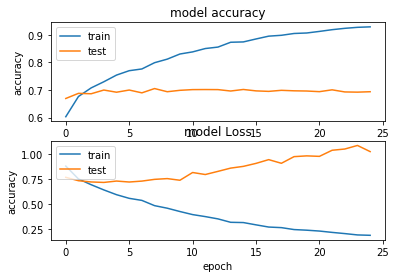

In [20]:
plt.subplot(211)  
#plt.figure(figsize=(15,10))
plt.plot(sc.history['acc'])  
plt.plot(sc.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

print("--------------------------------------")

plt.subplot(212)  
plt.plot(sc.history['loss'])  
plt.plot(sc.history['val_loss'])  
plt.title('model Loss')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

In [21]:
print(sc.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


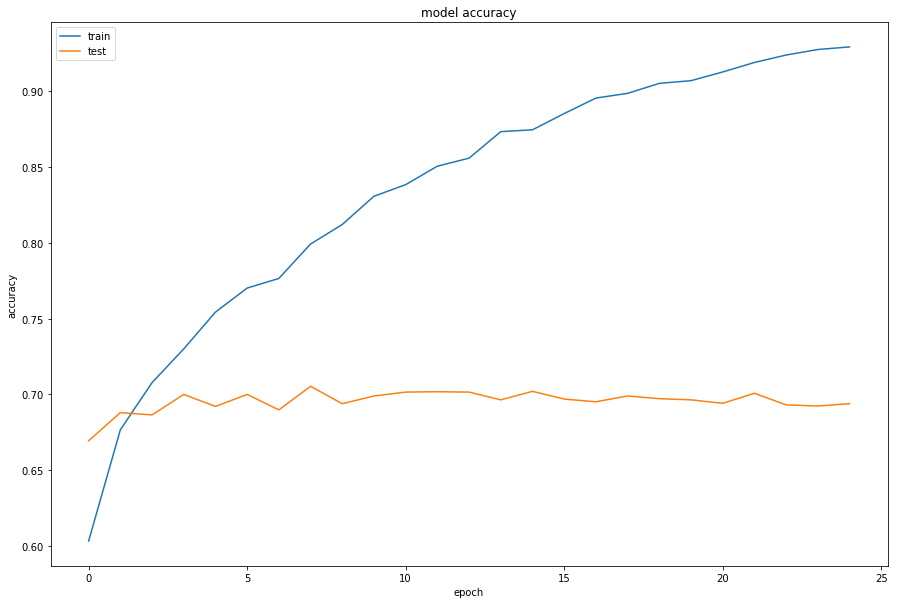

In [22]:
plt.figure(figsize=(15,10))
plt.plot(sc.history['acc'])  
plt.plot(sc.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

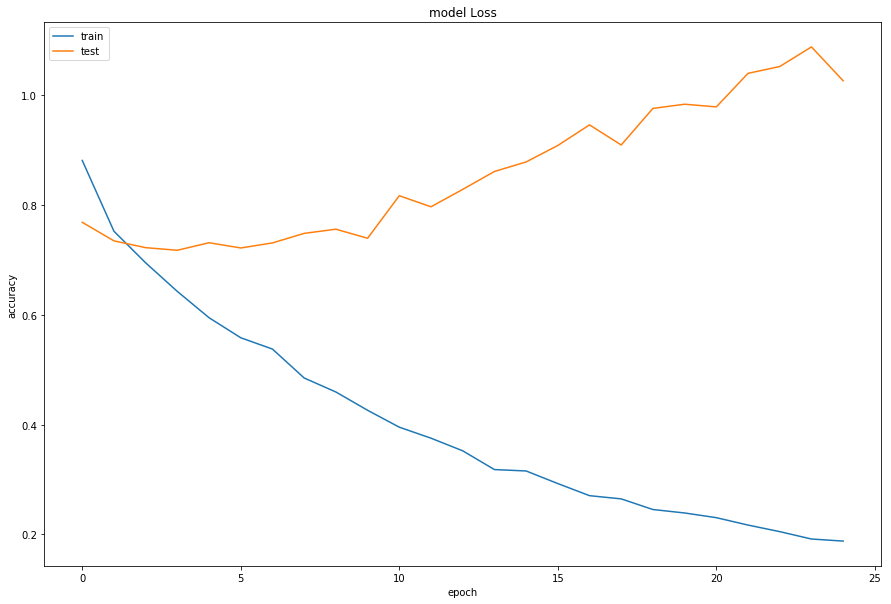

In [23]:
# plt.subplot(212)  
plt.figure(figsize=(15,10))
plt.plot(sc.history['loss'])  
plt.plot(sc.history['val_loss'])  
plt.title('model Loss')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

# LSTM NN

In [24]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)
xpred_seq = token.texts_to_sequences(test["text"])

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xpred_pad= sequence.pad_sequences(xpred_seq, maxlen=max_len)

word_index = token.word_index

In [25]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|████████████████████████████████████████████████████████████████████████| 25943/25943 [00:00<00:00, 260022.91it/s]


In [26]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 300)           7783200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 70, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
__________

In [28]:
scores = model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=25, verbose=1, validation_data=(xvalid_pad, yvalid_enc))


Train on 15663 samples, validate on 3916 samples
Epoch 1/25
15663/15663 [==============================] - ETA: 2:23 - loss: 1.1047 - acc: 0.369 - ETA: 1:47 - loss: 1.1066 - acc: 0.367 - ETA: 1:33 - loss: 1.1012 - acc: 0.382 - ETA: 1:23 - loss: 1.1074 - acc: 0.379 - ETA: 1:17 - loss: 1.1088 - acc: 0.382 - ETA: 1:11 - loss: 1.1078 - acc: 0.384 - ETA: 1:07 - loss: 1.1097 - acc: 0.382 - ETA: 1:03 - loss: 1.1077 - acc: 0.384 - ETA: 1:00 - loss: 1.1074 - acc: 0.384 - ETA: 1:01 - loss: 1.1056 - acc: 0.387 - ETA: 58s - loss: 1.1045 - acc: 0.387 - ETA: 55s - loss: 1.1037 - acc: 0.38 - ETA: 51s - loss: 1.1019 - acc: 0.38 - ETA: 48s - loss: 1.1013 - acc: 0.38 - ETA: 45s - loss: 1.1012 - acc: 0.38 - ETA: 42s - loss: 1.1007 - acc: 0.38 - ETA: 39s - loss: 1.0978 - acc: 0.39 - ETA: 35s - loss: 1.0973 - acc: 0.39 - ETA: 32s - loss: 1.0961 - acc: 0.39 - ETA: 29s - loss: 1.0948 - acc: 0.39 - ETA: 26s - loss: 1.0933 - acc: 0.39 - ETA: 23s - loss: 1.0930 - acc: 0.39 - ETA: 20s - loss: 1.0917 - acc: 0.40 

15663/15663 [==============================] - ETA: 1:44 - loss: 0.8434 - acc: 0.630 - ETA: 1:29 - loss: 0.8398 - acc: 0.627 - ETA: 1:21 - loss: 0.8338 - acc: 0.629 - ETA: 1:16 - loss: 0.8229 - acc: 0.632 - ETA: 1:12 - loss: 0.8209 - acc: 0.634 - ETA: 1:08 - loss: 0.8199 - acc: 0.634 - ETA: 1:05 - loss: 0.8155 - acc: 0.638 - ETA: 1:02 - loss: 0.8185 - acc: 0.638 - ETA: 59s - loss: 0.8210 - acc: 0.639 - ETA: 56s - loss: 0.8274 - acc: 0.63 - ETA: 54s - loss: 0.8252 - acc: 0.63 - ETA: 51s - loss: 0.8270 - acc: 0.63 - ETA: 48s - loss: 0.8270 - acc: 0.63 - ETA: 45s - loss: 0.8284 - acc: 0.63 - ETA: 42s - loss: 0.8290 - acc: 0.63 - ETA: 39s - loss: 0.8269 - acc: 0.63 - ETA: 37s - loss: 0.8242 - acc: 0.63 - ETA: 34s - loss: 0.8228 - acc: 0.63 - ETA: 31s - loss: 0.8204 - acc: 0.64 - ETA: 28s - loss: 0.8203 - acc: 0.63 - ETA: 25s - loss: 0.8185 - acc: 0.64 - ETA: 23s - loss: 0.8207 - acc: 0.63 - ETA: 20s - loss: 0.8212 - acc: 0.63 - ETA: 17s - loss: 0.8219 - acc: 0.63 - ETA: 14s - loss: 0.8189 

15663/15663 [==============================] - ETA: 1:11 - loss: 0.7112 - acc: 0.703 - ETA: 1:10 - loss: 0.7280 - acc: 0.687 - ETA: 1:06 - loss: 0.7344 - acc: 0.682 - ETA: 1:02 - loss: 0.7284 - acc: 0.686 - ETA: 59s - loss: 0.7348 - acc: 0.684 - ETA: 56s - loss: 0.7307 - acc: 0.68 - ETA: 54s - loss: 0.7370 - acc: 0.68 - ETA: 51s - loss: 0.7304 - acc: 0.69 - ETA: 48s - loss: 0.7309 - acc: 0.68 - ETA: 45s - loss: 0.7353 - acc: 0.68 - ETA: 43s - loss: 0.7364 - acc: 0.68 - ETA: 41s - loss: 0.7379 - acc: 0.68 - ETA: 39s - loss: 0.7377 - acc: 0.68 - ETA: 37s - loss: 0.7402 - acc: 0.68 - ETA: 35s - loss: 0.7324 - acc: 0.68 - ETA: 32s - loss: 0.7321 - acc: 0.68 - ETA: 30s - loss: 0.7339 - acc: 0.68 - ETA: 28s - loss: 0.7330 - acc: 0.68 - ETA: 26s - loss: 0.7312 - acc: 0.69 - ETA: 24s - loss: 0.7318 - acc: 0.68 - ETA: 21s - loss: 0.7309 - acc: 0.68 - ETA: 19s - loss: 0.7323 - acc: 0.68 - ETA: 17s - loss: 0.7324 - acc: 0.68 - ETA: 15s - loss: 0.7316 - acc: 0.68 - ETA: 12s - loss: 0.7316 - acc: 0

15663/15663 [==============================] - ETA: 1:00 - loss: 0.6965 - acc: 0.701 - ETA: 59s - loss: 0.6786 - acc: 0.707 - ETA: 57s - loss: 0.6641 - acc: 0.71 - ETA: 55s - loss: 0.6532 - acc: 0.71 - ETA: 52s - loss: 0.6649 - acc: 0.71 - ETA: 50s - loss: 0.6591 - acc: 0.71 - ETA: 49s - loss: 0.6589 - acc: 0.72 - ETA: 47s - loss: 0.6530 - acc: 0.72 - ETA: 45s - loss: 0.6548 - acc: 0.72 - ETA: 43s - loss: 0.6528 - acc: 0.72 - ETA: 41s - loss: 0.6498 - acc: 0.72 - ETA: 39s - loss: 0.6505 - acc: 0.72 - ETA: 37s - loss: 0.6538 - acc: 0.72 - ETA: 35s - loss: 0.6530 - acc: 0.72 - ETA: 33s - loss: 0.6530 - acc: 0.72 - ETA: 31s - loss: 0.6553 - acc: 0.72 - ETA: 29s - loss: 0.6532 - acc: 0.72 - ETA: 27s - loss: 0.6533 - acc: 0.72 - ETA: 25s - loss: 0.6548 - acc: 0.72 - ETA: 23s - loss: 0.6525 - acc: 0.72 - ETA: 20s - loss: 0.6536 - acc: 0.72 - ETA: 18s - loss: 0.6533 - acc: 0.72 - ETA: 16s - loss: 0.6539 - acc: 0.72 - ETA: 14s - loss: 0.6545 - acc: 0.72 - ETA: 12s - loss: 0.6545 - acc: 0.72 - 

15663/15663 [==============================] - ETA: 1:42 - loss: 0.5774 - acc: 0.746 - ETA: 1:35 - loss: 0.6174 - acc: 0.737 - ETA: 1:28 - loss: 0.6057 - acc: 0.748 - ETA: 1:24 - loss: 0.5969 - acc: 0.754 - ETA: 1:20 - loss: 0.5927 - acc: 0.754 - ETA: 1:16 - loss: 0.6008 - acc: 0.748 - ETA: 1:13 - loss: 0.6056 - acc: 0.748 - ETA: 1:09 - loss: 0.5944 - acc: 0.752 - ETA: 1:06 - loss: 0.5900 - acc: 0.754 - ETA: 1:02 - loss: 0.5853 - acc: 0.756 - ETA: 59s - loss: 0.5801 - acc: 0.760 - ETA: 56s - loss: 0.5796 - acc: 0.76 - ETA: 53s - loss: 0.5822 - acc: 0.75 - ETA: 50s - loss: 0.5822 - acc: 0.76 - ETA: 47s - loss: 0.5848 - acc: 0.75 - ETA: 44s - loss: 0.5838 - acc: 0.75 - ETA: 41s - loss: 0.5791 - acc: 0.76 - ETA: 38s - loss: 0.5783 - acc: 0.76 - ETA: 35s - loss: 0.5831 - acc: 0.75 - ETA: 31s - loss: 0.5836 - acc: 0.75 - ETA: 28s - loss: 0.5846 - acc: 0.75 - ETA: 25s - loss: 0.5849 - acc: 0.75 - ETA: 22s - loss: 0.5852 - acc: 0.75 - ETA: 19s - loss: 0.5843 - acc: 0.75 - ETA: 16s - loss: 0.5

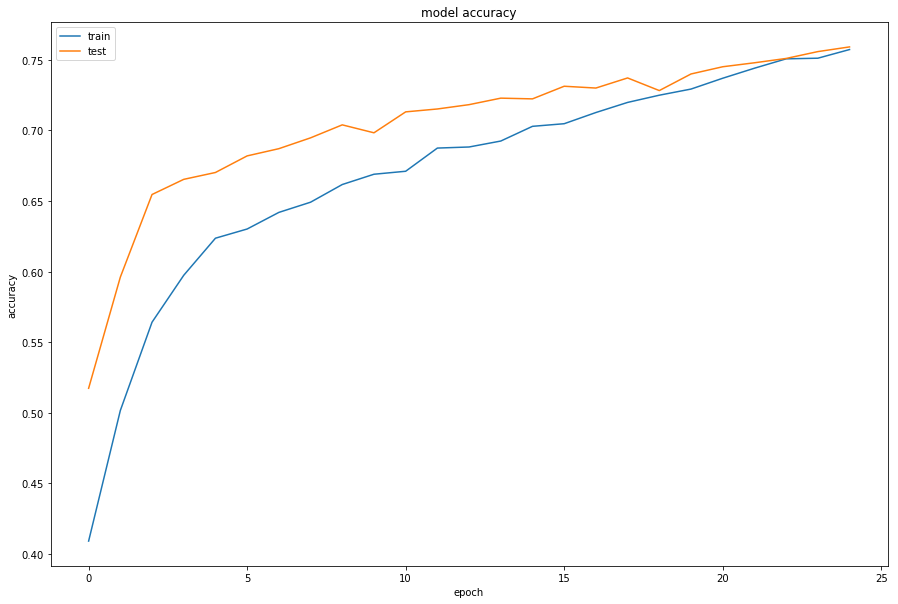

In [31]:
# plt.subplot(211)  
plt.figure(figsize=(15,10))
plt.plot(scores.history['acc'])  
plt.plot(scores.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

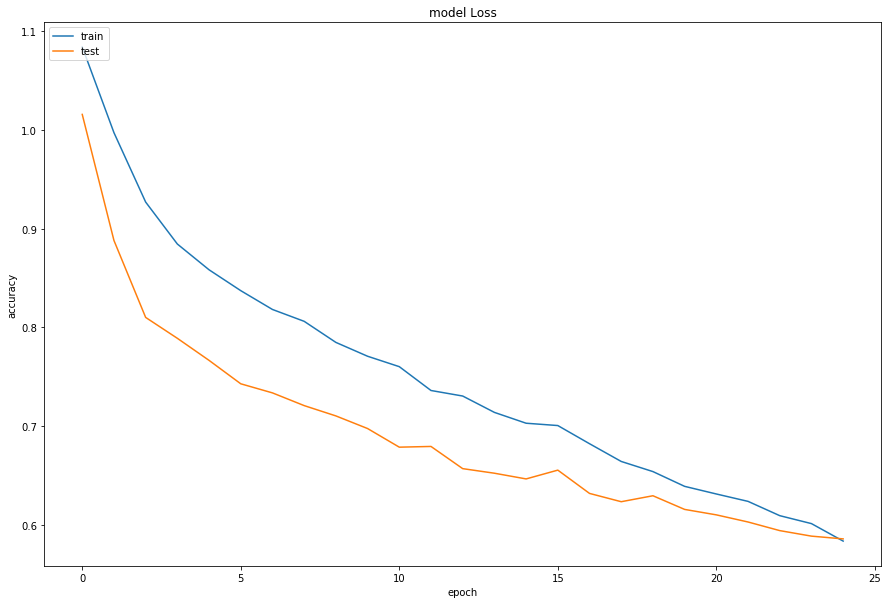

In [32]:
 # plt.subplot(212)  
plt.figure(figsize=(15,10))
plt.plot(scores.history['loss'])  
plt.plot(scores.history['val_loss'])  
plt.title('model Loss')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

In [33]:
ypred_prob_LSTM = model.predict(xpred_pad)

In [34]:
result_LSTM = pd.DataFrame(ypred_prob_LSTM, columns=['EAP_Prob','HPL_Prob','MWS_Prob'])
result_LSTM.insert(0, 'id', test['id'])
result_LSTM.insert(1, 'text', test['text'])
result_LSTM.head()

,id,text,EAP_Prob,HPL_Prob,MWS_Prob
0,id02310,"Still, as I urged our leaving Ireland with suc...",0.014348,0.025888,0.959765
1,id24541,"If a fire wanted fanning, it could readily be ...",0.950918,0.044707,0.004375
2,id00134,And when they had broken down the frail door t...,0.005152,0.992593,0.002254
3,id27757,While I was thinking how I should possibly man...,0.087543,0.848434,0.064023
4,id04081,I am not sure to what limit his knowledge may ...,0.348935,0.115697,0.535367


In [35]:
#writer = ExcelWriter('Predicted Author_LSTM.xlsx' , engine='xlsxwriter')
result_NN.to_excel(writer,sheet_name='LSTM',index=False,  columns=['id','text','EAP_Prob','HPL_Prob',
'MWS_Prob'])
writer.save

<bound method _XlsxWriter.save of <pandas.io.excel._XlsxWriter object at 0x000001A60E32BD68>>